In [1]:
!pip install pyvi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (Conv1D, Embedding, Input, Dense, Dropout, LSTM, GRU,
                                     Bidirectional, LayerNormalization, MaxPooling1D,
                                     GlobalMaxPooling1D, Concatenate)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer
from pyvi import ViUtils


In [ ]:
data = pd.read_csv("data-sentiment.csv")
data.head()

,comment,label,rate,Unnamed: 3
0,Áo bao đẹp ạ!!,POS,5,NaN
1,Tuyệt vời !,POS,5,NaN
2,2day ao khong giong trong.,NEG,1,NaN
3,"Mùi thơm,bôi lên da mềm da.",POS,5,NaN
4,"Vải đẹp, dày dặn.",POS,5,NaN


In [ ]:
sentiment_data=pd.DataFrame({'input': data['comment'],'label':data['label']})
sentiment_data=sentiment_data.dropna()
sentiment_data=sentiment_data.reset_index(drop=True)
sentiment_data.head()


,input,label
0,Áo bao đẹp ạ!!,POS
1,Tuyệt vời !,POS
2,2day ao khong giong trong.,NEG
3,"Mùi thơm,bôi lên da mềm da.",POS
4,"Vải đẹp, dày dặn.",POS


In [ ]:
input_data=sentiment_data['input'].values
input_label=sentiment_data['label'].values

label_dict={'NEG':0,'NEU':1,'POS':2}
input_pre=[]
label_with_accent=[]
for idx, dt in enumerate(input_data):
    input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(dt))
    input_text_pre = " ".join(input_text_pre)
    # Loại bỏ dấu tiếng Việt
    input_text_pre_no_accent = str(ViUtils.remove_accents(input_text_pre).decode("utf-8"))
    # Tokenize văn bản
    input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
    input_text_pre_no_accent = ViTokenizer.tokenize(input_text_pre_no_accent)
    input_pre.append(input_text_pre_accent)
    input_pre.append(input_text_pre_no_accent)
    label_with_accent.append(input_label[idx])
    label_with_accent.append(input_label[idx])

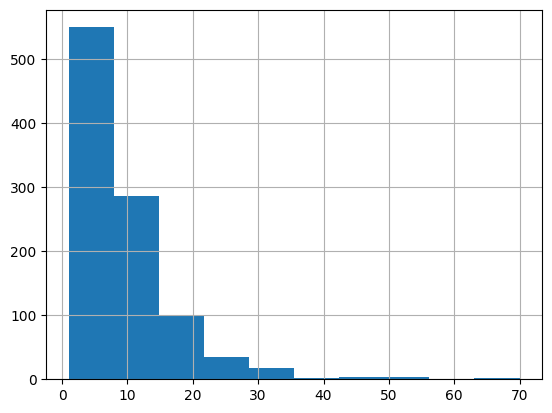

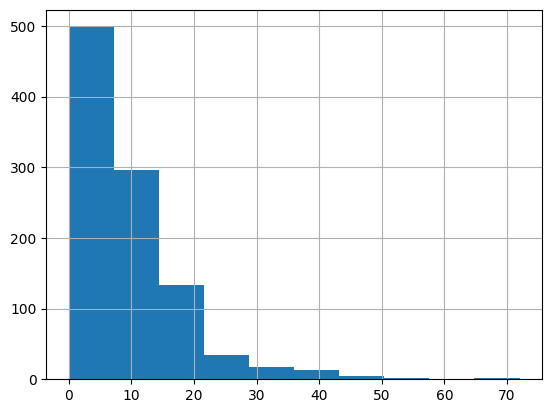

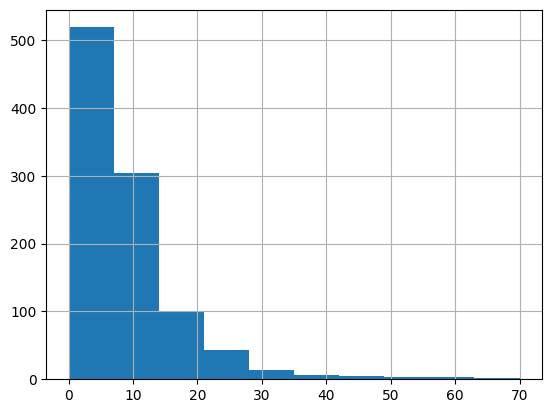

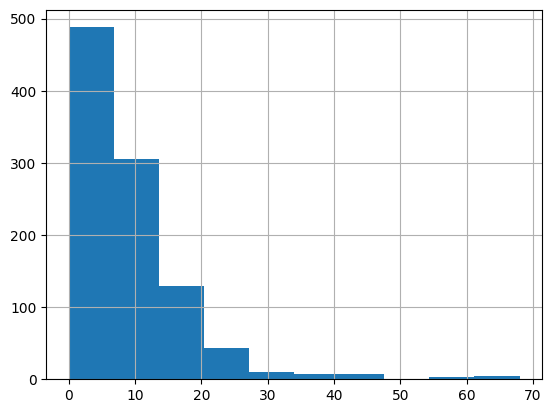

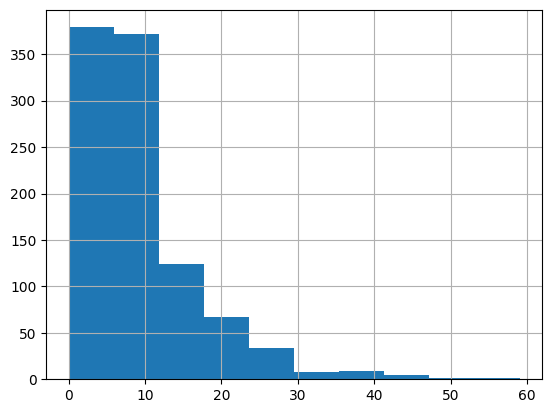

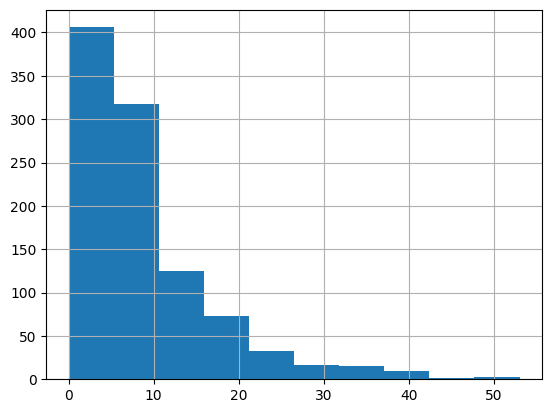

In [ ]:
seq_len = [len(i.split()) for i in input_pre[0:1000]]
pd.Series(seq_len).hist(bins=10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[1000:2000]]
pd.Series(seq_len).hist(bins=10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[2000:3000]]
pd.Series(seq_len).hist(bins=10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[3000:4000]]
pd.Series(seq_len).hist(bins=10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[4000:5000]]
pd.Series(seq_len).hist(bins=10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[5000:6000]]
pd.Series(seq_len).hist(bins=10)
plt.show()


In [ ]:
label_idx = [label_dict[i] for i in label_with_accent]
label_tf = tf.keras.utils.to_categorical(label_idx, num_classes=3).astype('float32')

tokenizer_data = Tokenizer(oov_token="<OOV>", filters='', split=' ')
tokenizer_data.fit_on_texts(input_pre)

tokenized_data_text = tokenizer_data.texts_to_sequences(input_pre)
vec_data = pad_sequences(tokenized_data_text, padding='post', maxlen=512)

pickle.dump(tokenizer_data, open("tokenizer_data.pkl", "wb"))

print("input data shape ", vec_data.shape)
data_vocab_size = len(tokenizer_data.word_index) + 1
print("data_vocab_size: ", data_vocab_size)

X_train, X_val, y_train, y_val = train_test_split(vec_data, label_tf, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print("training sample: ", len(X_train))
print("validation sample: ", len(X_val))
print("test sample: ", len(X_test))


input data shape  (62920, 512)
data_vocab_size:  9913
training sample:  45302
validation sample:  12584
test sample:  5034


## Create Model


In [ ]:
def generate_model():
    dropout_threshold = 0.4
    input_dim = data_vocab_size
    output_dim = 32
    input_length = 512
    initializer = tf.keras.initializers.GlorotNormal()

    input_layer = Input(shape=(input_length,))
    feature = Embedding(input_dim=input_dim, output_dim=output_dim,
                        input_length=input_length, embeddings_initializer='GlorotNormal')(input_layer)

    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(cnn_feature)
    ###
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = LayerNormalization()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)

    bi_lstm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold, return_sequences=True,kernel_initializer=initializer),merge_mode='concat')(feature)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
    bi_lstm_feature = Bidirectional(GRU(units=32, dropout=dropout_threshold, return_sequences=True,kernel_initializer=initializer),merge_mode='concat')(bi_lstm_feature)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)

    combine_feature = tf.keras.layers.Concatenate()([cnn_feature, bi_lstm_feature])
    combine_feature = GlobalMaxPooling1D()(combine_feature)
    combine_feature = LayerNormalization()(combine_feature)

    classifier = Dense(90, activation='relu')(combine_feature)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(70, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(50, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(30, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(3, activation='softmax')(classifier)

    model = tf.keras.Model(inputs=input_layer, outputs=classifier)

    return model

model = generate_model()
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 512, 32)        │        317,216 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 512, 32)        │          3,104 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 256, 32)        │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 32)        │              0 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 512, 64)        │         16,640 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 256, 32)        │          3,104 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 256, 64)        │              0 │ bidirectional[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 128, 32)        │              0 │ conv1d_1[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 256, 64)        │         18,816 │ max_pooling1d_2[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 128, 32)        │             64 │ max_pooling1d_1[0][0]  │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 128, 64)        │              0 │ bidirectional_1[0][0]  │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 32)        │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 128, 64)        │            128 │ max_pooling1d_3[0][0]  │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 96)        │              0 │ dropout_1[0][0],       │
│                           │                        │                │ layer_normalization_1… │
├──────────────────────

 Total params: 379,537 (1.45 MB)

 Trainable params: 379,537 (1.45 MB)

 Non-trainable params: 0 (0.00 B)

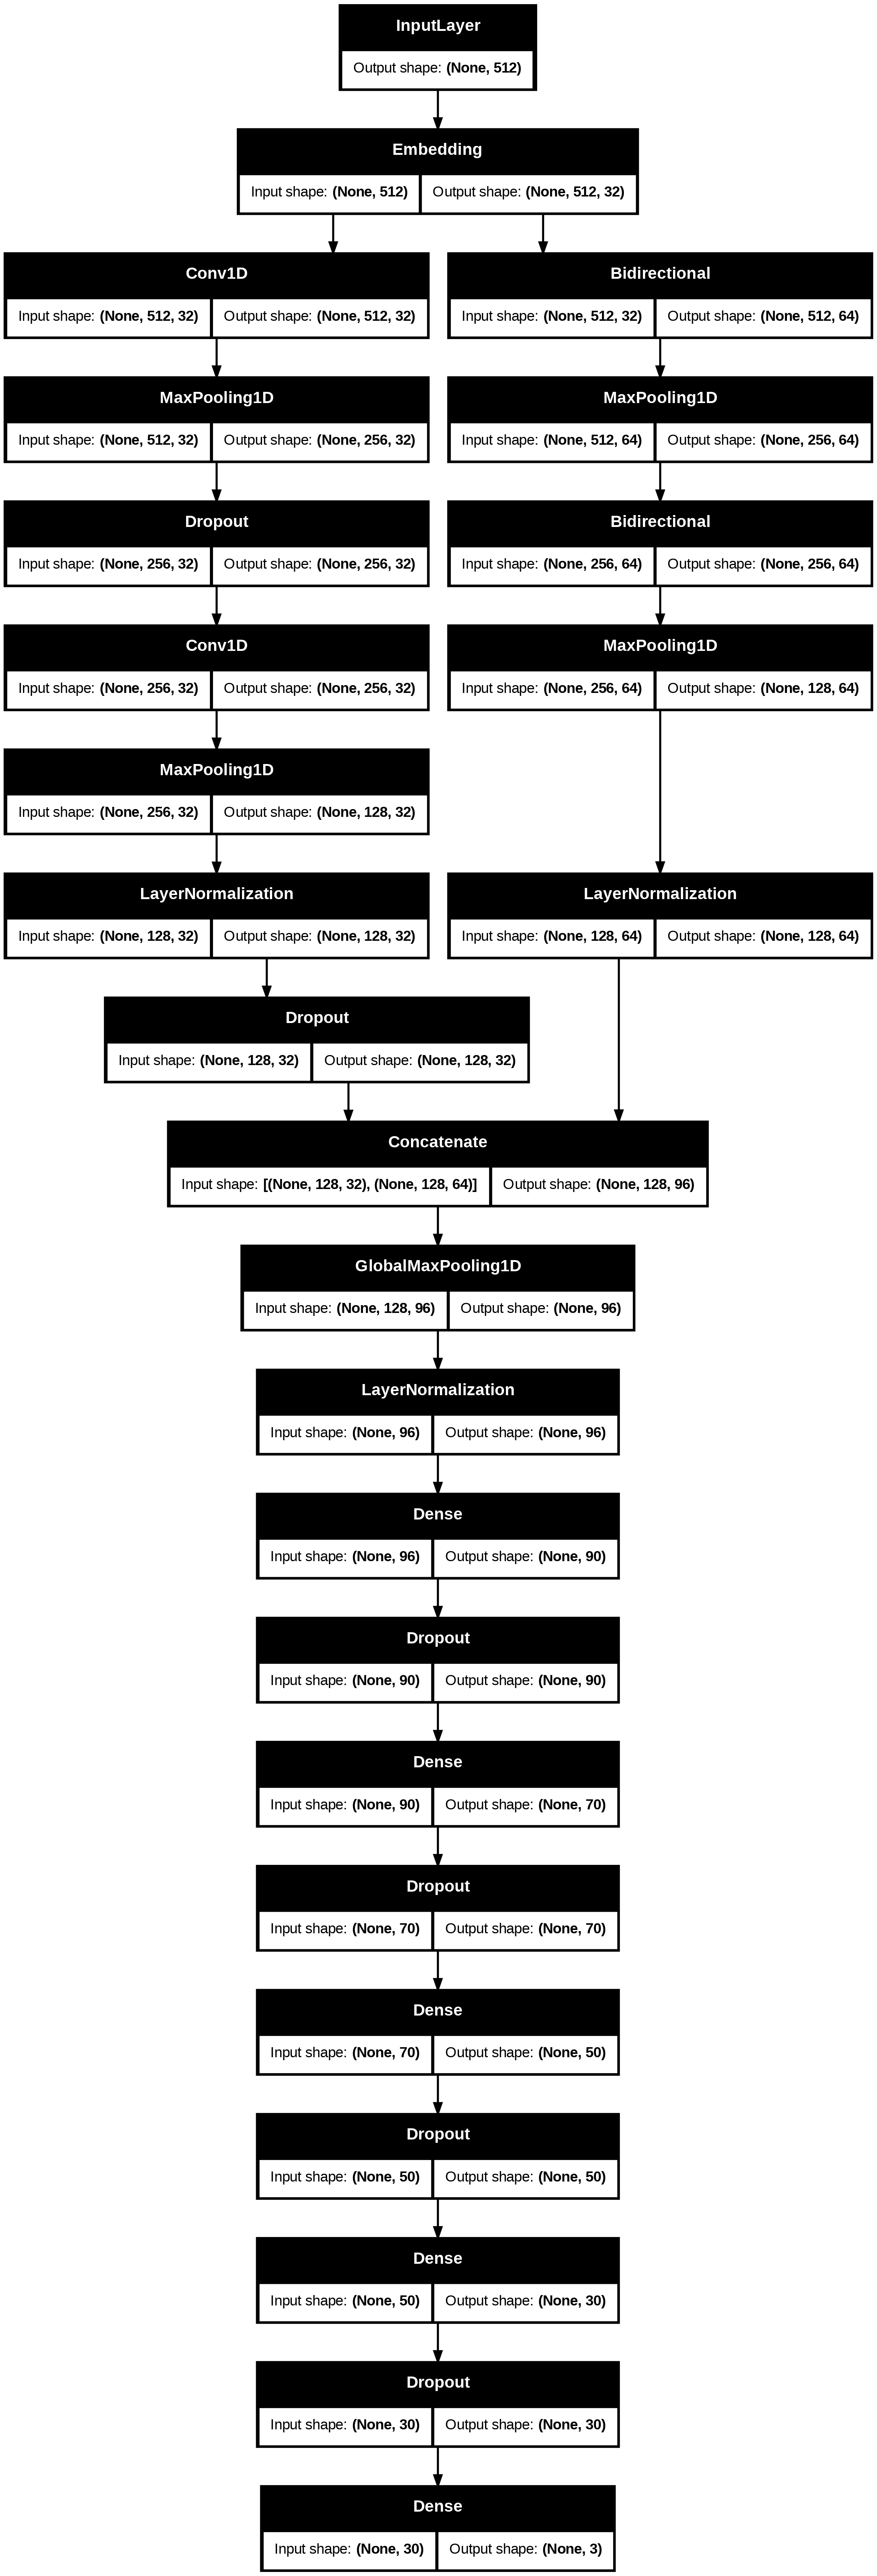

In [ ]:
import tensorflow as tf

# Định nghĩa tên file ảnh để lưu hình ảnh mô hình
dot_img_file = "model_visualize.png"

# Vẽ mô hình và lưu vào file ảnh
tf.keras.utils.plot_model(
    model,
    to_file=dot_img_file,
    show_shapes=True
)


In [ ]:
callback_model=tf.keras.callbacks.ModelCheckpoint('model_cnn_bilstm.h5',monitor='val_loss')
history=model.fit(x=X_train,y=y_train,batch_size=128,epochs=10,validation_data=(X_val,y_val),callbacks=[callback_model])

Epoch 1/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.6533 - loss: 0.8534

354/354 ━━━━━━━━━━━━━━━━━━━━ 252s 688ms/step - accuracy: 0.6534 - loss: 0.8531 - val_accuracy: 0.7806 - val_loss: 0.5474
Epoch 2/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.7824 - loss: 0.5649

354/354 ━━━━━━━━━━━━━━━━━━━━ 258s 728ms/step - accuracy: 0.7824 - loss: 0.5648 - val_accuracy: 0.7902 - val_loss: 0.5117
Epoch 3/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.7952 - loss: 0.5108

354/354 ━━━━━━━━━━━━━━━━━━━━ 269s 748ms/step - accuracy: 0.7952 - loss: 0.5108 - val_accuracy: 0.7901 - val_loss: 0.5102
Epoch 4/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.8059 - loss: 0.4795

354/354 ━━━━━━━━━━━━━━━━━━━━ 323s 750ms/step - accuracy: 0.8059 - loss: 0.4795 - val_accuracy: 0.7974 - val_loss: 0.5125
Epoch 5/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.8180 - loss: 0.4586

354/354 ━━━━━━━━━━━━━━━━━━━━ 322s 752ms/step - accuracy: 0.8180 - loss: 0.4586 - val_accuracy: 0.7951 - val_loss: 0.5067
Epoch 6/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.8285 - loss: 0.4291

354/354 ━━━━━━━━━━━━━━━━━━━━ 325s 761ms/step - accuracy: 0.8285 - loss: 0.4291 - val_accuracy: 0.7928 - val_loss: 0.5103
Epoch 7/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.8372 - loss: 0.4171

354/354 ━━━━━━━━━━━━━━━━━━━━ 322s 762ms/step - accuracy: 0.8372 - loss: 0.4171 - val_accuracy: 0.7973 - val_loss: 0.5240
Epoch 8/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.8436 - loss: 0.4053

354/354 ━━━━━━━━━━━━━━━━━━━━ 271s 767ms/step - accuracy: 0.8436 - loss: 0.4054 - val_accuracy: 0.7970 - val_loss: 0.5248
Epoch 9/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.8452 - loss: 0.3966

354/354 ━━━━━━━━━━━━━━━━━━━━ 273s 771ms/step - accuracy: 0.8452 - loss: 0.3966 - val_accuracy: 0.7926 - val_loss: 0.5322
Epoch 10/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.8526 - loss: 0.3870

354/354 ━━━━━━━━━━━━━━━━━━━━ 323s 772ms/step - accuracy: 0.8526 - loss: 0.3870 - val_accuracy: 0.7972 - val_loss: 0.5249


In [ ]:
# Tải trọng số của mô hình
model.load_weights("model_cnn_bilstm.h5")

# Đánh giá mô hình trên tập kiểm tra
model.evaluate(X_test, y_test)


NameError: name 'X_test' is not defined

In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preprocess_raw_input(raw_input, tokenizer):
    # Chuyển đổi văn bản thành danh sách từ
    input_text_pre = list(text_to_word_sequence(raw_input))
    input_text_pre = " ".join(input_text_pre)

    # Tokenize văn bản đầu vào
    tokenized_data_text = tokenizer.texts_to_sequences([input_text_pre])

    # Đệm chuỗi để đảm bảo độ dài cố định
    vec_data = pad_sequences(tokenized_data_text, padding="post", maxlen=512)

    return vec_data

def inference_model(input_feature, model):
    # Dự đoán đầu ra từ mô hình
    output = model(input_feature).numpy()[0]

    # Lấy chỉ mục của lớp có giá trị cao nhất
    result = np.argmax(output)

    # Ánh xạ chỉ mục sang nhãn
    label_dict = {0: "Tiêu cực", 1: "Trung lập", 2: "Tích cực"}
    label = label_dict[result]

    return label, float(np.max(output))

def prediction(raw_input, tokenizer, model):
    # Tiền xử lý dữ liệu đầu vào
    input_model = preprocess_raw_input(raw_input, tokenizer)

    # Dự đoán kết quả
    result, conf = inference_model(input_model, model)

    return result, conf

# Load mô hình đã được huấn luyện
my_model = tf.keras.models.load_model("model_cnn_bilstm_finetuned.h5")

# Load tokenizer đã được lưu
with open("tokenizer_data.pkl", "rb") as input_file:
    my_tokenizer = pickle.load(input_file)

# Kiểm thử với một câu đầu vào
while True:
    text = input("Nhập văn bản (hoặc gõ 'end' để thoát): ")

    if text.lower() == "end":
        break

    result, confidence = prediction(text, my_tokenizer, my_model)
    print(f"Kết quả: {result} | Độ tin cậy: {confidence:.2f}\n")

Nhập văn bản (hoặc gõ 'end' để thoát): sản phẩm chưa oke lắm
Kết quả: Tiêu cực | Độ tin cậy: 0.86

Nhập văn bản (hoặc gõ 'end' để thoát): sản phẩm oke tôi rất recommend
Kết quả: Tích cực | Độ tin cậy: 0.99

Nhập văn bản (hoặc gõ 'end' để thoát): Lần đầu mua thử nhưng thật sự ấn tượng, quần áo đẹp y hình, chất vải mềm mịn và đường may cực kỳ chỉn chu
Kết quả: Tích cực | Độ tin cậy: 0.99

Nhập văn bản (hoặc gõ 'end' để thoát): Đặt áo mà tưởng giao khăn trải bàn, form kiểu 'khó hiểu' cực kỳ.
Kết quả: Tiêu cực | Độ tin cậy: 0.66

Nhập văn bản (hoặc gõ 'end' để thoát): 12.	"Chất lượng sản phẩm quá kém so với giá tiền, cảm thấy không xứng đáng.
Kết quả: Tiêu cực | Độ tin cậy: 1.00



In [3]:
import pandas as pd

# Đọc file CSV mới
new_data = pd.read_csv("data_moi.csv", encoding='utf-8-sig')

# Xử lý như cũ
new_data = new_data.dropna()
new_data = new_data.reset_index(drop=True)

input_data_new = new_data['comment'].values
input_label_new = new_data['label'].values

In [4]:
from pyvi import ViTokenizer, ViUtils
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

input_pre_new = []
label_with_accent_new = []

for idx, dt in enumerate(input_data_new):
    input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(dt))
    input_text_pre = " ".join(input_text_pre)
    input_text_pre_no_accent = str(ViUtils.remove_accents(input_text_pre).decode("utf-8"))
    input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
    input_text_pre_no_accent = ViTokenizer.tokenize(input_text_pre_no_accent)

    input_pre_new.append(input_text_pre_accent)
    input_pre_new.append(input_text_pre_no_accent)

    label_with_accent_new.append(input_label_new[idx])
    label_with_accent_new.append(input_label_new[idx])

# Gán nhãn
label_dict = {'NEG': 0, 'NEU': 1, 'POS': 2}
label_idx_new = [label_dict[i] for i in label_with_accent_new]
label_tf_new = tf.keras.utils.to_categorical(label_idx_new, num_classes=3).astype('float32')

In [5]:
# Load lại tokenizer đã lưu
with open("tokenizer_data.pkl", "rb") as f:
    tokenizer_data = pickle.load(f)

tokenized_data_text_new = tokenizer_data.texts_to_sequences(input_pre_new)
vec_data_new = pad_sequences(tokenized_data_text_new, padding='post', maxlen=512)

In [7]:
from tensorflow.keras.optimizers import Adam

# Sau khi load model
model = tf.keras.models.load_model("model_cnn_bilstm.h5")

# Bắt buộc phải compile lại
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Tiếp tục huấn luyện
model.fit(x=vec_data_new, y=label_tf_new, batch_size=128, epochs=5)

# Lưu lại model đã fine-tuned
model.save("model_cnn_bilstm_finetuned.h5")


Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.7100 - loss: 0.7180
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7400 - loss: 0.6464
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7900 - loss: 0.5832    
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8000 - loss: 0.5338   
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8000 - loss: 0.4824   
